In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sympy
import dataset
# sympy.init_printing()

# 误差反向传播

## 计算图

## 链式法则

假设 $y = f(x) = x^2$，那么 ${\partial y \over \partial x} = 2x$

In [3]:
x, y, z, t = sympy.symbols("x, y, z, t")

In [4]:
t = x + y
t

x + y

In [5]:
z = t ** 2
z

(x + y)**2

In [6]:
sympy.diff(z, x)

2*x + 2*y

## 反向传播

### 加法节点的反向传播

In [7]:
z = x + y
z

x + y

In [8]:
sympy.diff(z, x), sympy.diff(z, y)

(1, 1)

In [9]:
class Layer(object):

    def forward(self, x):
        return NotImplementedError

    def backward(self, dz):
        return

    def update(self, lr=0.1):
        return

In [10]:
class AddLayer(Layer):

    def forward(self, x, y):
        return x + y

    def backward(self, dz):
        return dz, dz

## 乘法反向传播

In [11]:
z = x * y
z

x*y

In [12]:
sympy.diff(z, x), sympy.diff(z, y)

(y, x)

In [13]:
class MulLayer(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y

    def backward(self, dz):
        dx = dz * self.y
        dy = dz * self.x
        return dx, dy


In [14]:
apple = 100
applen = 2
tax = 1.1

mul_layer = MulLayer()
tax_layer = MulLayer()

apple_price = mul_layer.forward(apple, applen)
price = tax_layer.forward(apple_price, tax)
apple_price, price

(200, 220.00000000000003)

In [15]:
dprice = 1
apple_price, dtax = tax_layer.backward(dprice)
apple_price, dtax

(1.1, 200)

In [16]:
dapple, dapplen = mul_layer.backward(apple_price)
dapple, dapplen

(2.2, 110.00000000000001)

In [17]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

apple_layer = MulLayer()
orange_layer = MulLayer()

total_layer = AddLayer()
tax_layer = MulLayer()

In [18]:
apple_price = apple_layer.forward(apple, apple_num)
apple_price

200

In [19]:
orange_price = orange_layer.forward(orange, orange_num)
orange_price

450

In [20]:
total_price = total_layer.forward(apple_price, orange_price)
total_price

650

In [21]:
price = tax_layer.forward(total_price, tax)
price

715.0000000000001

In [22]:
dprice = 1
dtotal_price, dtax = tax_layer.backward(dprice)
dtotal_price, dtax

(1.1, 650)

In [23]:
dapple_price, dorange_price = total_layer.backward(dtotal_price)
dapple_price, dorange_price

(1.1, 1.1)

In [24]:
dorange, dorange_num = orange_layer.backward(dorange_price)
dorange, dorange_num

(3.3000000000000003, 165.0)

In [25]:
dapple, dapple_num = apple_layer.backward(dapple_price)
dapple, dapple_num

(2.2, 110.00000000000001)

## 激活函数层的实现

### ReLU

In [26]:
class ReluLayer(Layer):

    def forward(self, x):
        self.mask = (x <= 0)
        y = x.copy()
        y[self.mask] = 0
        return y

    def backward(self, dy):
        dy[self.mask] = 0
        return dy

## Sigmoid

In [27]:
z = 1 / (1 + sympy.exp(-x))
z

1/(1 + exp(-x))

In [28]:
sympy.diff(z, x)

exp(-x)/(1 + exp(-x))**2

由于


$$
\begin{aligned}
& e^{-x} \over (1 + e^{-x})^2  \\
=&  {1 \over 1 + e^{-x}}  \cdot {e^{-x} \over 1 + e^{-x} } \\
=&  {1 \over 1 + e^{-x}}  \cdot {1 + e^{-x} - 1 \over 1 + e^{-x} } \\
=&  {1 \over 1 + e^{-x}}  \cdot \left(1 -  {1 \over 1 + e^{-x}}\right) \\
=& z * (1 - z)
\end{aligned}
$$

所以

In [29]:
class SigmoidLayer(Layer):

    def forward(self, x: np.ndarray):
        self.y = 1 / (1 + np.exp(-x))
        return self.y

    def backward(self, dy):
        dx = dy * (1.0 - self.y) * self.y
        return dx

## Affine 仿射层的实现

In [30]:
X = np.random.rand(2)
X

array([0.88563391, 0.15228979])

In [31]:
W = np.random.randn(2, 3)
W

array([[ 0.52578321,  0.05126723,  0.83438995],
       [-0.95576578,  0.12987515, -0.70017792]])

In [32]:
B = np.random.randn(3)
B

array([ 1.96932289, -0.48591403,  0.3372435 ])

In [33]:
Y = np.dot(X, W) + B
Y

array([ 2.28942096, -0.42073138,  0.96957759])

In [34]:
X = sympy.Matrix(sympy.symbols('x_1, x_2')).T
X

Matrix([[x_1, x_2]])

In [35]:
W = sympy.Matrix([
    sympy.symbols("w_{11}, w_{12}, w_{13}"),
    sympy.symbols("w_{21}, w_{22}, w_{23}")
])
W

Matrix([
[w_{11}, w_{12}, w_{13}],
[w_{21}, w_{22}, w_{23}]])

In [36]:
X * W

Matrix([[w_{11}*x_1 + w_{21}*x_2, w_{12}*x_1 + w_{22}*x_2, w_{13}*x_1 + w_{23}*x_2]])

In [37]:
B = sympy.Matrix(sympy.symbols('b_1, b_2, b_3')).T
B

Matrix([[b_1, b_2, b_3]])

In [38]:
Z = X * W + B
Z

Matrix([[b_1 + w_{11}*x_1 + w_{21}*x_2, b_2 + w_{12}*x_1 + w_{22}*x_2, b_3 + w_{13}*x_1 + w_{23}*x_2]])

In [39]:
DX = sympy.diff(Z, X)
DX

[[[[w_{11}, w_{12}, w_{13}]], [[w_{21}, w_{22}, w_{23}]]]]

In [40]:
DW = sympy.diff(Z, W)
DW

[[[[x_1, 0, 0]], [[0, x_1, 0]], [[0, 0, x_1]]], [[[x_2, 0, 0]], [[0, x_2, 0]], [[0, 0, x_2]]]]

In [41]:
class AffineLayer(Layer):

    def __init__(self, input, output) -> None:
        self.w = np.random.randn(input, output)
        self.b = np.random.randn(output)

    def forward(self, x):
        self.x = x
        y = np.dot(x, self.w) + self.b
        return y

    def backward(self, dy):
        dx = np.dot(dy, self.w.T)
        self.dw = np.dot(self.x.T, dy)
        self.db = np.sum(dy, axis=0)
        return dx

    def update(self, lr=0.1):
        self.w -= self.dw * lr
        self.b -= self.db * lr

## SoftLoss 层

In [42]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def cross_entropy_error(y: np.ndarray, t: np.ndarray):
    if y.ndim == 1:
        y = y.reshape(1, y.size)
    if t.ndim == 1:
        t = t.reshape(1, t.size)

    batch_size = y.shape[0]

    if t.shape == y.shape:
        return -np.sum(t * np.log(y + 1e-7)) / batch_size
    else:
        return -np.sum(
            np.log(
                y[np.arange(batch_size), t] + 1e-7
            )
        ) / batch_size

In [43]:
class SoftLossLayer(Layer):

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        return dx

## 反向传播的实现

In [44]:
class TwoLayerNet(object):

    def __init__(self, input_size, hidden_size, output_size):
        self.layers = [
            AffineLayer(input_size, hidden_size),
            ReluLayer(),
            AffineLayer(hidden_size, hidden_size),
            ReluLayer(),
            AffineLayer(hidden_size, output_size),
        ]

        self.losslayer = SoftLossLayer()

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def accuracy(self, x, t):
        y = self.forward(x)
        y = np.argmax(y, axis=1)

        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        return np.sum(y == t) / float(x.shape[0])

    def loss(self, x, t):
        self.l = self.forward(x)
        return self.losslayer.forward(self.l, t)

    def update(self, lr=0.1):
        dy = self.l * lr
        dy = self.losslayer.backward(dy)

        for layer in self.layers[::-1]:
            dy = layer.backward(dy)

        for layer in self.layers[::-1]:
            layer.update(lr)

In [45]:
x_train = np.array([[0.1, 0.1], [0.1, 1.0], [1.0, 0.1], [1.0, 1.0]])
t_train = np.array([[1, 0], [0, 1], [0, 1], [1, 0]])

In [46]:
net = TwoLayerNet(2, 30, 2)

In [47]:
# np.seterr(all="ignore")
# np.seterr(all='raise')

epoch = 1000
lr = 0.1

x_batch = x_train
t_batch = t_train

loss_list = []

bar = tqdm(range(epoch))

for e in bar:

    loss = net.loss(x_batch, t_batch)
    net.update(lr)

    loss_list.append(loss)

    acc = net.accuracy(x_batch, t_batch) * 100

    bar.set_postfix(dict(acc=f'{acc:.2f}%', loss=f'{loss:.3f}', lr=f'{lr:.3f}'))

100%|██████████| 1000/1000 [00:01<00:00, 600.92it/s, acc=100.00%, loss=0.000, lr=0.100]


In [48]:
for x in x_train:
    y = net.forward(x)
    y = softmax(y)
    print(x, y, np.argmax(y))

[0.1 0.1] [9.99865494e-01 1.34506471e-04] 0
[0.1 1. ] [2.95716865e-04 9.99704283e-01] 1
[1.  0.1] [4.09618200e-04 9.99590382e-01] 1
[1. 1.] [9.99574055e-01 4.25945376e-04] 0


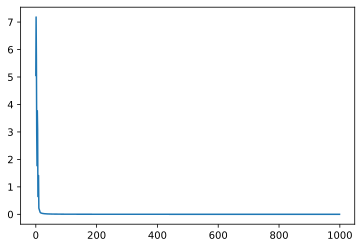

In [49]:
axes = plt.figure().add_subplot()
axes.plot(loss_list)
plt.show()